In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.stats import norm
import torch
import torch.nn as nn
from torch.autograd import Variable
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
import keras

In [ ]:
# define the standalone discriminator model
def define_discriminator(n_inputs=1):
 model = Sequential()
 model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
 model.add(Dense(1, activation='sigmoid'))
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
 return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=1):
 model = Sequential()
 model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
 model.add(Dense(n_outputs, activation='linear'))
 return model

def define_gan(generator, discriminator):
 # make weights in the discriminator not trainable
 discriminator.trainable = False
 # connect them
 model = Sequential()
 # add generator
 model.add(generator)
 # add the discriminator
 model.add(discriminator)
 # compile model
 model.compile(loss='binary_crossentropy', optimizer='adam')
 return model

# generate n real samples with class labels
def generate_real_samples(n):
 # generate inputs in [-0.5, 0.5]
 X = np.random.normal(0, 1,n).reshape(n, 1)
 # generate class labels
 y = ones((n, 1))
 return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
 # generate points in the latent space
 x_input = np.random.uniform(0,1,n)#randn(latent_dim * n)
 # reshape into a batch of inputs for the network
 #x_input = x_input.reshape(n, latent_dim)
 return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
 # generate points in latent space
 x_input = generate_latent_points(latent_dim, n)
 print(f"Generated gaussian RV : {x_input}")
 # predict outputs
 X = generator.predict(x_input)
 # create class labels
 y = zeros((n, 1))
 print(f"Generator output : {X},{y}")
 return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
 # prepare real samples
 x_real, y_real = generate_real_samples(n)
 # evaluate discriminator on real examples
 _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
 # prepare fake examples
 x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
 # evaluate discriminator on fake examples
 _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
 # summarize discriminator performance
 print(f"epoch : {epoch},acc_real : {acc_real},acc_fake : {acc_fake}")
 print(f"Fake Data : {x_fake}")
 # scatter plot real and fake data points
 xs = np.linspace(0, n, n)
 pyplot.scatter(xs,x_real[:, 0] ,color='red')
 pyplot.scatter(xs,x_fake[:, 0], color='blue')
 pyplot.show()



In [ ]:
# size of the latent space
latent_dim = 1
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim,1)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
#train(generator, discriminator, gan_model, latent_dim)

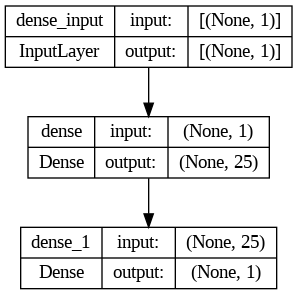

In [ ]:
keras.utils.plot_model(discriminator,show_shapes=True, show_layer_names=True)

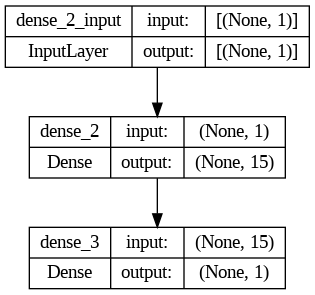

In [ ]:
keras.utils.plot_model(generator,show_shapes=True, show_layer_names=True)

In [ ]:
D_real_accuracy = []
D_fake_accuracy = []
G_accuracy = []
D_real_loss = []
D_fake_loss = []
G_loss = []

In [ ]:
def plot_metrics(D_real_loss,D_real_accuracy,D_fake_loss,D_fake_accuracy,G_loss,G_accuracy):
  print("Loss Plot:\n")
  plt.plot(D_real_loss)
  plt.plot(D_fake_loss)
  plt.plot(G_loss)
  plt.show()
  print("Accuracy Plot:\n")
  plt.plot(D_real_accuracy)
  plt.plot(D_fake_accuracy)
  plt.plot(G_accuracy)
  plt.show()


In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10, n_batch=100, n_eval=2):
 # determine half the size of one batch, for updating the discriminator
 half_batch = int(n_batch)
 # manually enumerate epochs
 for i in range(n_epochs):
  # prepare real samples
  print(f"\n\n Epoch {i}")
  x_real, y_real = generate_real_samples(n_batch)
  for j in range(n_batch):
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, 1)
    # update discriminator
    print(f"x_real : {x_real[j]},y_real : {y_real[j]}")
    print(f"x_fake : {x_fake},y_fake : {y_fake}")
    real_train_metrics = d_model.train_on_batch(x_real[j], y_real[j],return_dict=True)
    fake_train_metrics = d_model.train_on_batch(x_fake, y_fake,return_dict=True)
    print(f"sample {j} : Real Metrics : {real_train_metrics}")
    print(f"sample {j} : Fake Metrics : {fake_train_metrics}")
    D_real_loss.append(real_train_metrics['loss'])
    D_real_accuracy.append(real_train_metrics['accuracy'])
    D_fake_loss.append(fake_train_metrics['loss'])
    D_fake_accuracy.append(fake_train_metrics['accuracy'])
    plot_metrics(D_real_loss,D_real_accuracy,D_fake_loss,D_fake_accuracy,G_loss,G_accuracy)
    # prepare points in latent space as input for the generator
    x_gan = generate_latent_points(latent_dim, 1)
    # create inverted labels for the fake samples
    y_gan = ones((1, 1))
    # update the generator via the discriminator's error
    gan_model.train_on_batch(x_gan, y_gan)
    # evaluate the model every n_eval epochs
  #if i % n_eval == 0:
    #summarize_performance(i, g_model, d_model, latent_dim,1)

In [ ]:
train(generator, discriminator, gan_model, latent_dim)

In [ ]:
def plotHistogram(real,sample_size,lowerlim,upperlim):
  xs_pre = np.linspace(lowerlim, upperlim, sample_size)
  histc, edges = np.histogram(real, sample_size, density=True)
  max_histc = np.max(histc)
  min_histc = np.min(histc)
  y_ = (histc - min_histc) / (max_histc - min_histc)
  plt.plot(xs_pre,y_)

4/4 [==============================] - 0s 2ms/step
<class 'numpy.ndarray'>
[-1.5515542  -1.5244346  -1.5143306  -1.5121326  -1.4889697  -1.453782
 -1.4470686  -1.4443709  -1.4370961  -1.4246287  -1.4231534  -1.3905134
 -1.3814876  -1.3693472  -1.3641232  -1.3471307  -1.3442898  -1.3347932
 -1.3233596  -1.3207915  -1.3195629  -1.319449   -1.2999214  -1.2999177
 -1.2832745  -1.2796094  -1.2416489  -1.1875566  -1.185811   -1.1842681
 -1.1691658  -1.1688986  -1.1644887  -1.1601199  -1.1500915  -1.1419226
 -1.1378751  -1.1279104  -1.1115177  -1.1108451  -1.1007448  -1.0992707
 -1.0826234  -1.0750253  -1.0703809  -1.0673453  -1.0661931  -1.0582225
 -1.0575196  -1.0474874  -1.0230969  -1.019194   -1.0128564  -0.9688399
 -0.9547031  -0.93640745 -0.92082584 -0.90275574 -0.86169183 -0.8583628
 -0.83684075 -0.83358324 -0.8314198  -0.8208591  -0.8163434  -0.78940034
 -0.78784716 -0.7806885  -0.7364068  -0.7202579  -0.70232    -0.70071745
 -0.69428426 -0.69367385 -0.68513453 -0.67491364 -0.633021  

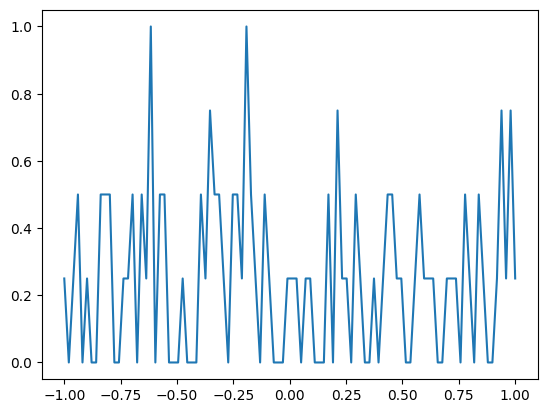

In [ ]:
input = np.random.uniform(0,1,100)
res = generator.predict(input)
res = np.sort(res.reshape(100,))
print(type(res))
print(res)
plotHistogram(res,100,-1,1)